In [1]:
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=16,processes=1,memory="47GB")
client = Client(cluster)
cluster.scale(cores=48)

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.152:34677,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
print(client)

<Client: 'tcp://10.0.128.152:34677' processes=0 threads=0, memory=0 B>


In [4]:
cd /g/data/fu5/deg581/OSSE_analysis/notebooks/

/g/data1a/fu5/deg581/OSSE_analysis/notebooks


In [5]:
### run my startup script
exec(open("../src/functions/fun_loadStartup.py").read())
### load my functions
exec(open("../src/functions/fun_loadMyFunctions.py").read())

%config InlineBackend.figure_format='png'

### Load grid
grdFile = '../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc'
grid = loadRomsGrid(grdFile)


loaded my modules
loaded my own functions
loading ROMS grid from ../data/raw/EACouter_varres_grd_mergedBLbry_uhroms.nc


In [6]:
### new loads
import numpy.matlib
from xgcm import Grid
import matplotlib.ticker as mticker
import xroms
import matplotlib.dates as mdates


### Load functions

In [7]:
### Other local functions

def loadOSSE(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = glob.glob(hisFilePath+prefix+filestring)

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

#     for files in filelist: 
#         print(files)
    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

### function to load overlapping OSSE data
def loadOverlappedNetcdf(hisFilePath,prefix,filestring='0*.nc',overlapDays=7):
    chunks = {'ocean_time':1}
    filelist = sorted(glob.glob(hisFilePath+prefix+filestring))

    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def dropDuplicateTimes(inputData):
    _, index = np.unique(inputData['ocean_time'], return_index=True)
    out = inputData.isel(ocean_time=index)
    return out

def calc_rmseSpatial(input1,input2,etaRange,xiRange):
    err2 = (input1-input2)**2
    # err=err2**(1/2)
    mse = indexMeanMetric(err2,etaRange,xiRange) #mean square error MSE
    output = mse**(1/2)
    return mse,output

# define function for calculating spatial mean
def indexMeanMetric(input,etaRange,xiRange):
    ''' iRange and jRange are converted to slices, so they are the start/end values of the range '''
    output = input.isel(eta_rho=slice(etaRange[0],etaRange[1]), xi_rho=slice(xiRange[0],xiRange[1])).mean(dim='eta_rho', skipna=True).mean(dim='xi_rho', skipna=True)
    return output

def simple_TimeSeries(inputDataX, inputDataY, plt_kwargs={}, ax=None):
    #Plotting
    if ax is None:
        ax = plt.gca()   
    hOut = ax.plot(inputDataX, inputDataY, **plt_kwargs)
    ax.grid(color='black', alpha=0.2, linestyle='--')
    return(hOut)

def plot_spatialMapSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def plot_spatialMapGSSubplot(toPlotData, ax=None, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    #Plotting
    if ax is None:
        ax = plt.gca()
    # plt.subplot(projection=ccrs.PlateCarree())
#     ax = fig.add_subplot(gs[ax], projection=ccrs.PlateCarree())
    ax.set_extent([147, 162.5, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    toPlotData.plot.contour('lon_rho','lat_rho',ax=ax, **cont_kwargs)
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
        #gl.xformatter = LONGITUDE_FORMATTER
        #gl.yformatter = LATITUDE_FORMATTER
    gl.right_labels = False
    gl.top_labels = False
    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)

def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

def datestring_to_serial_day(datestring,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import pandas as pd
    import datetime
    serial_day_timedelta = pd.to_datetime(datestring) - datetime.datetime(epochY,epochm,epochd,epochH,epochM)
    corrected_serial_day_number = serial_day_timedelta.days + serial_day_timedelta.seconds/86400
    return corrected_serial_day_number


def serial_day_to_datestring(day,epochY=1990,epochm=1,epochd=1,epochH=0,epochM=0):
    import datetime
    corrected_date = datetime.datetime(epochY,epochm,epochd,epochH,epochM) + datetime.timedelta(day)
    return corrected_date.strftime("%Y-%m-%d %H:%M")


def spatialMap_addGSSubplot(toPlotData, gs, nrow,ncol, labelText, pcol_kwargs={}, cont_kwargs={}, kde_kwargs={}):
    ax = fig.add_subplot(gs[nrow,ncol], projection=ccrs.PlateCarree())
    ax.set_extent([148, 161, -42, -25])
    feature = ax.add_feature(Coast, edgecolor='black',facecolor='gray')
    im=toPlotData.plot.pcolormesh('lon_rho','lat_rho',ax=ax, add_colorbar=False, **pcol_kwargs)       
    gl = ax.gridlines(draw_labels=True,
                     color='black', alpha=0.2, linestyle='--')
    gl.right_labels = False
    gl.top_labels = False
    gl.xlocator = mticker.FixedLocator(np.arange(150,160))
    gl.ylocator = mticker.FixedLocator(np.arange(-45,45))

    cax = inset_axes(ax,
                 width="5%",  # width = 10% of parent_bbox width
                 height="50%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(.07,.39, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
    fig.colorbar(im, cax=cax)
    ax.text(0.01, 0.99, labelText, transform=ax.transAxes,fontsize=12, fontweight='bold', va='top')
    ax.set_title('')
    return ax

In [8]:
### Functions for calculating metrics

def loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates):
    filenameForecast=hisOSSEFilePath+prefixForecast+'0'+str(dates)+'.nc'
    filenameAnalysis=hisOSSEFilePath+prefixAnalysis+'0'+str(dates)+'.nc'
    sshForecast=xr.open_dataset(filenameForecast).zeta.load()
    sshAnalysis=xr.open_dataset(filenameAnalysis).zeta.load()
    sstForecast=xr.open_dataset(filenameForecast).temp.isel(s_rho=-1).load()
    sstAnalysis=xr.open_dataset(filenameAnalysis).temp.isel(s_rho=-1).load()
    return sshForecast, sshAnalysis, sstForecast, sstAnalysis

def loadTruthdata(hisTruthFilePath,prefixTruth,dates):
    filenameTruth   =hisTruthFilePath+prefixTruth+'0'+str(dates)+'.nc'
    sshTruth   =xr.open_dataset(filenameTruth).zeta.load()
    sstTruth=xr.open_dataset(filenameTruth).temp.isel(s_rho=-1).load()
    return sshTruth, sstTruth

def compileOSSETimeMetricSSH(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            ssh_metricForecast = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricForecast = xr.merge([ssh_metricForecast, temp])
            temp = indexMeanMetric(sshAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricAnalysis = xr.merge([ssh_metricAnalysis, temp])
    return ssh_metricForecast,ssh_metricAnalysis

def compileOSSETimeMetricSST(hisOSSEFilePath,prefixForecast,prefixAnalysis,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshForecast,sshAnalysis,sstForecast,sstAnalysis = loadOSSEdata(hisOSSEFilePath,prefixForecast,prefixAnalysis,dates)       
        if dates == datelist[0]:
            sst_metricForecast = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sstForecast, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricForecast = xr.merge([sst_metricForecast, temp])
            temp = indexMeanMetric(sstAnalysis, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricAnalysis = xr.merge([sst_metricAnalysis, temp])
    return sst_metricForecast,sst_metricAnalysis

def compileTruthTimeMetric(hisTruthFilePath,prefixTruth,etaRangeMetric,xiRangeMetric,datelist):
    for dates in datelist:
        sshTruth,sstTruth = loadTruthdata(hisTruthFilePath,prefixTruth,dates)
        if dates == datelist[0]:
            ssh_metricTruth = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
        elif dates != datelist[0]:
            temp = indexMeanMetric(sshTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            ssh_metricTruth = xr.merge([ssh_metricTruth, temp])
            temp = indexMeanMetric(sstTruth, etaRange=etaRangeMetric, xiRange=xiRangeMetric).to_dataset(name = str(dates))
            sst_metricTruth = xr.merge([sst_metricTruth, temp])
    return ssh_metricTruth, sst_metricTruth

In [9]:
### Functions for loading and processing ROMS data nicely... ROMS FUNCTIONS

from xgcm import Grid

def processROMSGrid(ds):
    ds = ds.rename({'eta_u': 'eta_rho', 'xi_v': 'xi_rho', 'xi_psi': 'xi_u', 'eta_psi': 'eta_v'})

    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
        'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
        'Z':{'center':'s_rho', 'outer':'s_w'}}

    grid = Grid(ds, coords=coords, periodic=[])

    if ds.Vtransform == 1:
        Zo_rho = ds.hc * (ds.s_rho - ds.Cs_r) + ds.Cs_r * ds.h
        z_rho = Zo_rho + ds.zeta * (1 + Zo_rho/ds.h)
        Zo_w = ds.hc * (ds.s_w - ds.Cs_w) + ds.Cs_w * ds.h
        z_w = Zo_w + ds.zeta * (1 + Zo_w/ds.h)
    elif ds.Vtransform == 2:
        Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
        z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho
        Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
        z_w = Zo_w * (ds.zeta + ds.h) + ds.zeta

    ds.coords['z_w'] = z_w.where(ds.mask_rho, 0).transpose('ocean_time', 's_w', 'eta_rho', 'xi_rho')
    ds.coords['z_rho'] = z_rho.where(ds.mask_rho, 0).transpose('ocean_time', 's_rho', 'eta_rho', 'xi_rho')
    # Other Option is to transpose arrays and fill NaNs with a minimal depth
    # ds['z_rho'] = z_rho.transpose(*('time', 's_rho','yh','xh'),transpose_coords=False).fillna(hmin)
    # ds['z_w'] = z_w.transpose(*('time', 's_w','yh','xh'),transpose_coords=False).fillna(hmin)
    ds.coords['z_rho0'] = z_rho.mean(dim='ocean_time')
    ds.coords['z_w0'] = z_w.mean(dim='ocean_time')

     # interpolate depth of levels at U and V points
    ds['z_u'] = grid.interp(ds['z_rho'], 'X', boundary='fill')
    ds['z_v'] = grid.interp(ds['z_rho'], 'Y', boundary='fill')

    ds['pm_v'] = grid.interp(ds.pm, 'Y')
    ds['pn_u'] = grid.interp(ds.pn, 'X')
    ds['pm_u'] = grid.interp(ds.pm, 'X')
    ds['pn_v'] = grid.interp(ds.pn, 'Y')
    ds['pm_psi'] = grid.interp(grid.interp(ds.pm, 'Y'),  'X') # at psi points (eta_v, xi_u) 
    ds['pn_psi'] = grid.interp(grid.interp(ds.pn, 'X'),  'Y') # at psi points (eta_v, xi_u)

    ds['dx'] = 1/ds.pm
    ds['dx_u'] = 1/ds.pm_u
    ds['dx_v'] = 1/ds.pm_v
    ds['dx_psi'] = 1/ds.pm_psi

    ds['dy'] = 1/ds.pn
    ds['dy_u'] = 1/ds.pn_u
    ds['dy_v'] = 1/ds.pn_v
    ds['dy_psi'] = 1/ds.pn_psi

    ds['dz'] = grid.diff(ds.z_w, 'Z', boundary='fill')
    ds['dz0'] = grid.diff(ds.z_w0, 'Z', boundary='fill')
    ds['dz_w'] = grid.diff(ds.z_rho, 'Z', boundary='fill')
    ds['dz_u'] = grid.interp(ds.dz, 'X')
    ds['dz_w_u'] = grid.interp(ds.dz_w, 'X')
    ds['dz_v'] = grid.interp(ds.dz, 'Y')
    ds['dz_w_v'] = grid.interp(ds.dz_w, 'Y')

    ds['dA'] = ds.dx * ds.dy

    metrics = {
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    grid = Grid(ds, coords=coords, metrics=metrics, periodic=[])

    return ds

def makeROMSGridObject(gridIn):
    coords={'X':{'center':'xi_rho', 'inner':'xi_u'}, 
    'Y':{'center':'eta_rho', 'inner':'eta_v'}, 
    'Z':{'center':'s_rho', 'outer':'s_w'}}
    metrics={
        ('X',): ['dx', 'dx_u', 'dx_v', 'dx_psi'], # X distances
        ('Y',): ['dy', 'dy_u', 'dy_v', 'dy_psi'], # Y distances
        ('Z',): ['dz', 'dz_u', 'dz_v', 'dz_w', 'dz_w_u', 'dz_w_v'], # Z distances
        ('X', 'Y'): ['dA'] # Areas
    }
    gridOut = Grid(gridIn, coords=coords, metrics=metrics, periodic=[])
    return gridOut

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho'],
                                    method='linear').squeeze()
    return output

In [10]:

def loadOSSEFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadOverlappedNetcdfFileList(hisFilePath,prefix,filelist,overlapDays=7):
    chunks = {'ocean_time':1}
    def preprocessRemoveLastDay(ds):
        '''remove the last 7 timesteps from each file'''
        return ds.isel(ocean_time = slice(0,-overlapDays))

    outName = xr.open_mfdataset(filelist,chunks, preprocess=preprocessRemoveLastDay, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def loadNetcdfFileListAverages(hisFilePath,prefix,filelist):

    outName = xr.open_mfdataset(filelist, data_vars='minimal', compat='override', coords='minimal', parallel=True, join='right') 
    print('loaded from '+filelist[0]+' to '+filelist[-1])
    return outName

def generateFileList(hisFilePath,prefix,datelist):
    filelist=[hisFilePath+prefix+'0'+str(datelist[0])+'.nc']
    for dates in datelist[1:]:
        filenameToAppend=hisFilePath+prefix+'0'+str(dates)+'.nc'
        filelist.append(filenameToAppend)

#         print(filelist)
    return filelist

# downsample data to daily.
def calc_dailyDownsample(ds):
    ds_withtime = ds.drop([ var for var in ds.variables if not 'ocean_time' in ds[var].dims ])
    ds_timeless = ds.drop([ var for var in ds.variables if     'ocean_time' in ds[var].dims ])
    ds_workaround = xr.merge([ds_timeless, ds_withtime.resample(ocean_time='5D').mean('ocean_time')])
    return ds_workaround

# calculate EKE metrics
def calc_timeMeanEKE(input):
    u_eastward_top = input.u_eastward.isel(s_rho=-1)
    v_northward_top = input.v_northward.isel(s_rho=-1)

    u_bar = u_eastward_top.mean("ocean_time")
    v_bar = v_northward_top.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward_top - u_bar
    v_prime = v_northward_top - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)

    eketimemean = (eke*input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(input.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return eketimemean

def calc_MKEandEKElevel(input,level):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.isel(s_rho=level).mean("ocean_time")
    v_bar = v_northward.isel(s_rho=level).mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward.isel(s_rho=level) - u_bar
    v_prime = v_northward.isel(s_rho=level) - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def calc_MKEandEKEall(input):
    u_eastward = input.u_eastward
    v_northward = input.v_northward

    u_bar = u_eastward.mean("ocean_time")
    v_bar = v_northward.mean("ocean_time")

    mke = 0.5*(u_bar**2 + v_bar**2)

    u_prime = u_eastward - u_bar
    v_prime = v_northward - v_bar

    eke = 0.5*(u_prime**2 + v_prime**2)
    
    input['mke']=mke
    input['eke']=eke
    return input

def horizontalSectionROMS(grid,inputVal,targetDepth):
    # v2
    output = grid.transform(inputVal, 'Z', targetDepth,
                                    target_data=inputVal['z_rho0'],
                                    method='linear').squeeze()
    return output

def calc_areaAverageROMS(input,grid):
    output = (input*grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)/(grid.dA).sum(dim=['eta_rho','xi_rho'],skipna=True)
    return output

def calc_areaMedianROMS(input,grid):
    output = input*(grid.dA/grid.dA.sum(dim=['eta_rho','xi_rho'],skipna=True))
    output = np.median(output.values.flatten())
    return output

def process_trimVarsROMS(input,varsKeep):
    output_backup = input
    output = input[varsKeep]
    return output,output_backup

def calc_volTrans(input,etaLocation,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked.isel(eta_rho=transectEta)*input.dz.isel(eta_rho=transectEta)*input.dx.isel(eta_rho=transectEta)).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSlice(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw<=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_volTransSliceNorth(input,velCutoff,depthCutoff,lonCutoff):
    input_nw = input.v_northward
    input_masked = input_nw.where(input_nw>=velCutoff).where(input.z_rho>depthCutoff).where(input_nw.lon_rho<lonCutoff)
    output = (input_masked*input.dz*input.dx).sum(dim='s_rho').sum(dim='xi_rho')
    return output

def calc_depthAverageROMS(input,grid,etaTransect):
    dz = grid.dz.mean(dim='ocean_time').isel(eta_rho=etaTransect)
    dx = grid.dx.isel(eta_rho=etaTransect)
    output = ((input*dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True))/(dz*dx).sum(dim=['xi_rho','s_rho'],skipna=True)
    return output

In [11]:
hisTruthFilePath='/g/data/fu5/deg581/EAC_2yr_truthRun_obsVerification/output/' # Truth file settings

hisOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
modOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'
obsOSSEFilePath1='/g/data/fu5/eac/OSSEs/OSSE_ssh_sst_is4dvar/output/'

hisOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
modOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'
obsOSSEFilePath2='/g/data/fu5/deg581/OSSE_SSHSST_XBT/output/'

hisOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
modOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'
obsOSSEFilePath3='/g/data/fu5/deg581/OSSE_SSHSST_XBT_NORTH/output/'

hisOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
modOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'
obsOSSEFilePath4='/g/data/fu5/deg581/OSSE_SSHSST_XBT_SOUTH/output/'

prefixForecast='roms_fwd_outer0_'
prefixAnalysis='roms_fwd_outer1_'
prefixAverage='roms_avg_outer1_'
prefixTruth='outer_his_'
prefixTruthAverage='outer_avg_'

prefixObs='obs_0'
prefixMod='eac_mod_'
prefixPert='outer_his_'

outFigurePath='../cache/out/'

In [12]:
timeRange = [8005, 8401]
datelist = np.array(range(timeRange[0],timeRange[1],4))

In [13]:
# Load zeta data
VarToKeep = ['temp','z_rho0']#'dx','dy','dz']#,'salt','rho'],'dA','dx','dy','dz']

outputPath = '/g/data/fu5/deg581/OSSE_analysis/data/proc/'
outputPrefix = 'output_'
expNames=['truth','OSSE_SSHSST','OSSE_SSHSST_XBT','OSSE_SSHSST_XBT_N','OSSE_SSHSST_XBT_S']
outputSuffix = '_'+str(timeRange[0])+'_'+str(timeRange[1])+'.nc'
filelistTruth = outputPath+outputPrefix+expNames[0]+outputSuffix
filelist_SSHSST=outputPath+outputPrefix+expNames[1]+outputSuffix
filelist_SSHSST_XBT=outputPath+outputPrefix+expNames[2]+outputSuffix
filelist_SSHSST_XBT_N=outputPath+outputPrefix+expNames[3]+outputSuffix
filelist_SSHSST_XBT_S=outputPath+outputPrefix+expNames[4]+outputSuffix

truth = xr.open_dataset(filelistTruth)
OSSE_SSHSST= xr.open_dataset(filelist_SSHSST)
OSSE_SSHSST_XBT= xr.open_dataset(filelist_SSHSST_XBT)
OSSE_SSHSST_XBT_N= xr.open_dataset(filelist_SSHSST_XBT_N)
OSSE_SSHSST_XBT_S= xr.open_dataset(filelist_SSHSST_XBT_S)


#load grid file
grid = makeROMSGridObject(truth)

truth,truth_bu = process_trimVarsROMS(truth,VarToKeep)
OSSE_SSHSST,OSSE_SSHSST_bu = process_trimVarsROMS(OSSE_SSHSST,VarToKeep)
OSSE_SSHSST_XBT_S,OSSE_SSHSST_XBT_S_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_S,VarToKeep)
OSSE_SSHSST_XBT_N,OSSE_SSHSST_XBT_N_bu = process_trimVarsROMS(OSSE_SSHSST_XBT_N,VarToKeep)
OSSE_SSHSST_XBT,OSSE_SSHSST_XBT_bu = process_trimVarsROMS(OSSE_SSHSST_XBT,VarToKeep)

truth = truth.drop('z_rho')
OSSE_SSHSST = OSSE_SSHSST.drop('z_rho')
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop('z_rho')
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop('z_rho')
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop('z_rho')

# # Add in time invariable depth coords and vol metrics
truth['dz0']=truth_bu.dz.mean(dim='ocean_time')
truth['dV']=truth_bu.dx*truth_bu.dy*truth.dz0.compute()

OSSE_SSHSST['dz0']=OSSE_SSHSST_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST['dV']=OSSE_SSHSST_bu.dx*OSSE_SSHSST_bu.dy*OSSE_SSHSST.dz0.compute()

OSSE_SSHSST_XBT_S['dz0']=OSSE_SSHSST_XBT_S_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_S['dV']=OSSE_SSHSST_XBT_S_bu.dx*OSSE_SSHSST_XBT_S_bu.dy*OSSE_SSHSST_XBT_S.dz0.compute()

OSSE_SSHSST_XBT_N['dz0']=OSSE_SSHSST_XBT_N_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT_N['dV']=OSSE_SSHSST_XBT_N_bu.dx*OSSE_SSHSST_XBT_N_bu.dy*OSSE_SSHSST_XBT_N.dz0.compute()

OSSE_SSHSST_XBT['dz0']=OSSE_SSHSST_XBT_bu.dz.mean(dim='ocean_time')
OSSE_SSHSST_XBT['dV']=OSSE_SSHSST_XBT_bu.dx*OSSE_SSHSST_XBT_bu.dy*OSSE_SSHSST_XBT.dz0.compute()






In [14]:
truth

<xarray.Dataset>
Dimensions:     (ocean_time: 80, s_rho: 30, eta_rho: 317, xi_rho: 272)
Coordinates:
    z_rho0      (eta_rho, xi_rho, s_rho) float64 ...
  * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
    lon_rho     (eta_rho, xi_rho) float64 ...
    lat_rho     (eta_rho, xi_rho) float64 ...
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-12-31
Dimensions without coordinates: eta_rho, xi_rho
Data variables:
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 ...
    dz0         (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 3.178 3.178
    dV          (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... 1.09e+08 9.308e+07
Attributes: (12/31)
    file:              outer_his.nc
    format:            netCDF-3 64bit offset file
    Conventions:       CF-1.4, SGRID-0.3
    type:              ROMS/TOMS history file
    title:             EAC OUTER GRID
    var_info:          varinfo.dat
    ...                ...
    compiler_command:  /apps/openmpi/4.0.3/bin/mpif90
    compiler_flags:    -fp-model precise -heap-arrays -ip -O3 -traceback -che...
    tiling:            020x024
    history:           ROMS/TOMS, Version 3.9, Thursday - October 14, 2021 - ...
    ana_file:          ROMS/Functionals/ana_btflux.h
    CPP_options:       EAC, ANA_BSFLUX, ANA_BTFLUX, ASSUMED_SHAPE, AVERAGES, ...

In [15]:
time_range_to_load = slice('2012-01-01','2013-01-01')

truth = truth.sel(ocean_time=time_range_to_load)
OSSE_SSHSST = OSSE_SSHSST.sel(ocean_time=time_range_to_load)
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.sel(ocean_time=time_range_to_load)
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.sel(ocean_time=time_range_to_load)
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.sel(ocean_time=time_range_to_load)

In [16]:
OSSE_SSHSST_XBT.nbytes/1024/1024

1520.9197387695312

In [17]:
truth.load(), print('done')
OSSE_SSHSST.load(), print('done')
OSSE_SSHSST_XBT_N.load(), print('done')
OSSE_SSHSST_XBT_S.load(), print('done')
OSSE_SSHSST_XBT.load(), print('done')


done
done
done
done
done


(<xarray.Dataset>
 Dimensions:     (ocean_time: 74, s_rho: 30, eta_rho: 317, xi_rho: 272)
 Coordinates:
     z_rho0      (eta_rho, xi_rho, s_rho) float64 nan nan nan ... -4.487 -1.039
   * s_rho       (s_rho) float64 -0.9715 -0.9156 -0.8614 ... -0.0156 -0.004799
     lon_rho     (eta_rho, xi_rho) float64 147.1 147.1 147.2 ... 162.2 162.2
     lat_rho     (eta_rho, xi_rho) float64 -38.5 -38.51 -38.52 ... -28.15 -28.16
   * ocean_time  (ocean_time) datetime64[ns] 2012-01-01 2012-01-06 ... 2012-12-31
 Dimensions without coordinates: eta_rho, xi_rho
 Data variables:
     temp        (ocean_time, s_rho, eta_rho, xi_rho) float64 nan nan ... 23.58
     dz0         (s_rho, eta_rho, xi_rho) float64 0.0 0.0 0.0 ... 3.178 3.178
     dV          (eta_rho, xi_rho, s_rho) float64 0.0 0.0 ... 1.09e+08 9.308e+07
 Attributes: (12/39)
     file:              roms_fwd_outer1.nc
     format:            netCDF-3 64bit offset file
     Conventions:       CF-1.4, SGRID-0.3
     type:              ROMS/TOMS h

In [18]:
def calc_boxSpatial(grid,etaRange,xiRange):
    pt00lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01lo = grid['lon_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11lo = grid['lon_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    pt00la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[0]).values
    pt01la = grid['lat_rho'].isel(eta_rho=etaRange[0],xi_rho=xiRange[1]).values
    pt10la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[0]).values
    pt11la = grid['lat_rho'].isel(eta_rho=etaRange[1],xi_rho=xiRange[1]).values
    boxLo = np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
    boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    return boxLo,boxLa

# etaRangeMetric = [84, 114] #[115, 200]
# xiRangeMetric = [149, 184] #[85, 150]

# boxLo,boxLa = calc_boxSpatial(grid,etaRange=etaRangeMetric,xiRange=xiRangeMetric)

a SSH+SST 700 0.017564946769475804
a XBT-S 700 0.011175711525078024
a XBT-N 700 0.00896021123210069
a XBT 700 0.010392517024219401
a SSH+SST 2000 0.02027538098292261
a XBT-S 2000 0.0134322385577283
a XBT-N 2000 0.01251764543925237
a XBT 2000 0.015398918061567462
b SSH+SST 700 0.03515406739854539
b XBT-S 700 0.00933624696394126
b XBT-N 700 0.01502696750752156
b XBT 700 0.017734143320221288
b SSH+SST 2000 0.026946372874146276
b XBT-S 2000 0.008308916794444801
b XBT-N 2000 0.0083351891911183
b XBT 2000 0.01177206849677552
c SSH+SST 700 0.019081853622333077
c XBT-S 700 0.009457029171286883
c XBT-N 700 0.009929506336613885
c XBT 700 0.009009556549603177
c SSH+SST 2000 0.017589583536698265
c XBT-S 2000 0.008590221899908466
c XBT-N 2000 0.011099110944557377
c XBT 2000 0.012404700785165501
CHANGE TO IN SITU TEMPERATURE!


/local/m68/deg581/tmp/ipykernel_579696/3248276485.py:465: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


<Figure size 432x288 with 0 Axes>

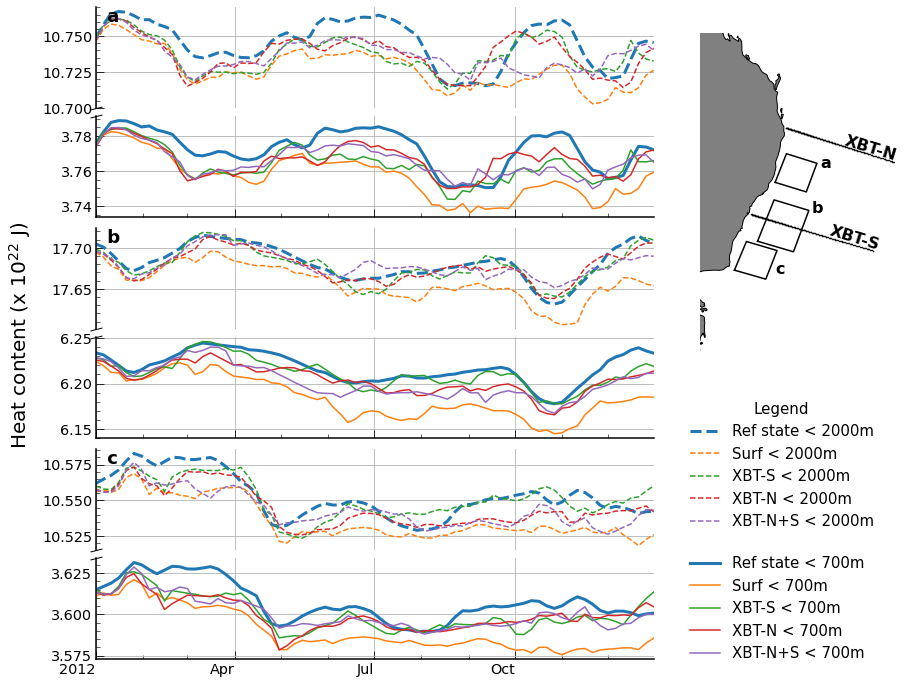

In [21]:
# consolidated plot of all OHCs

# set up figure
gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,12])
ax = None

rho0=1026
cp0=3850

divideBy = 1e22


gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,0],hspace=0.075)
gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,0],hspace=0.075)
gs2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[2,0],hspace=0.075)



# now look at mid-coast EAC box
etas = np.array([174,219])
xis = np.array([100,170])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}
cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy

ax = fig.add_subplot(gs0.new_subplotspec((0, 0), colspan=2))
ax2 = fig.add_subplot(gs0.new_subplotspec((1, 0), colspan=2))
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST_XBT < 700m',color='C4',linestyle='-')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

RMS_SSHSST_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_S_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_N_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5

print('a SSH+SST 700',RMS_SSHSST_OHC700.values)
print('a XBT-S 700',RMS_SSHSST_XBT_S_OHC700.values)
print('a XBT-N 700',RMS_SSHSST_XBT_N_OHC700.values)
print('a XBT 700',RMS_SSHSST_XBT_OHC700.values)

RMS_SSHSST_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_S_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_N_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5

print('a SSH+SST 2000',RMS_SSHSST_OHC2000.values)
print('a XBT-S 2000',RMS_SSHSST_XBT_S_OHC2000.values)
print('a XBT-N 2000',RMS_SSHSST_XBT_N_OHC2000.values)
print('a XBT 2000',RMS_SSHSST_XBT_OHC2000.values)


ax.set_xlabel('')
ax.set_xticklabels(())
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", which='major', direction='in', length=8)
ax.tick_params(axis="y", which='major', direction='in', length=8)
ax.minorticks_on()
ax.tick_params(axis="x", which='minor', direction='in', length=4)
ax.tick_params(axis="y", which='minor', direction='in', length=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set(xticklabels=[])
ax.text(0.01, 0.99, ' a', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')
ax.tick_params(axis="x", which="both", length=0)
ax.autoscale(enable=True, axis='x', tight=True)


ax2.set_xlabel('')
ax2.set_xticklabels(())
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
# ax.tick_params(axis="x", which="both", length=0)
# ax.tick_params(labeltop="off")
ax2.tick_params(labeltop="off")
ax2.xaxis.tick_bottom()
ax2.tick_params(axis="x", which='major', direction='in', length=8)
ax2.tick_params(axis="y", which='major', direction='in', length=8)
ax2.minorticks_on()
ax2.tick_params(axis="x", which='minor', direction='in', length=4)
ax2.tick_params(axis="y", which='minor', direction='in', length=4)
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.tick_params(axis='y', rotation=0, labelsize='x-large')
ax2.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
ax2.autoscale(enable=True, axis='x', tight=True)
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(1.5)
ax2.set(xticklabels=[])

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0], [0], transform=ax.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)
ax.grid()
ax2.grid()



# now look at high EKE variability box
etas = np.array([84,149])
xis = np.array([114,184])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}
cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy

ax = fig.add_subplot(gs1.new_subplotspec((0, 0), colspan=2))
ax2 = fig.add_subplot(gs1.new_subplotspec((1, 0), colspan=2))
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='Ref state < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='Surf < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='XBT-S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='XBT-N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='XBT-N+S < 700m',color='C4',linestyle='-')


truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='Ref state < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='Surf < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='XBT-S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='XBT-N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='XBT-N+S < 2000m',color='C4',linestyle='--')



RMS_SSHSST_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_S_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_N_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5

print('b SSH+SST 700',RMS_SSHSST_OHC700.values)
print('b XBT-S 700',RMS_SSHSST_XBT_S_OHC700.values)
print('b XBT-N 700',RMS_SSHSST_XBT_N_OHC700.values)
print('b XBT 700',RMS_SSHSST_XBT_OHC700.values)

RMS_SSHSST_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_S_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_N_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5

print('b SSH+SST 2000',RMS_SSHSST_OHC2000.values)
print('b XBT-S 2000',RMS_SSHSST_XBT_S_OHC2000.values)
print('b XBT-N 2000',RMS_SSHSST_XBT_N_OHC2000.values)
print('b XBT 2000',RMS_SSHSST_XBT_OHC2000.values)

ax.set_xlabel('')
ax.set_xticklabels(())
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", which='major', direction='in', length=8)
ax.tick_params(axis="y", which='major', direction='in', length=8)
ax.minorticks_on()
ax.tick_params(axis="x", which='minor', direction='in', length=4)
ax.tick_params(axis="y", which='minor', direction='in', length=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set(xticklabels=[])
ax.text(0.01, 0.99, ' b', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')
ax.tick_params(axis="x", which="both", length=0)
ax.autoscale(enable=True, axis='x', tight=True)


ax2.set_xlabel('')
ax2.set_xticklabels(())
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
# ax.tick_params(axis="x", which="both", length=0)
# ax.tick_params(labeltop="off")
ax2.tick_params(labeltop="off")
ax2.xaxis.tick_bottom()
ax2.tick_params(axis="x", which='major', direction='in', length=8)
ax2.tick_params(axis="y", which='major', direction='in', length=8)
ax2.minorticks_on()
ax2.tick_params(axis="x", which='minor', direction='in', length=4)
ax2.tick_params(axis="y", which='minor', direction='in', length=4)
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(1.5)
ax2.set(xticklabels=[])

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0], [0], transform=ax.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)
ax.grid()
ax2.grid()




# now look at Junde's UOHC box
etas = np.array([34,79])
xis = np.array([89,159])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}
cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy

ax = fig.add_subplot(gs2.new_subplotspec((0, 0), colspan=2))
ax2 = fig.add_subplot(gs2.new_subplotspec((1, 0), colspan=2))
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='Ref state < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='Surf < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='XBT-S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='XBT-N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='XBT-N+S < 700m',color='C4',linestyle='-')
# ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='Ref state < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='Surf < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='XBT-S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='XBT-N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='XBT-N+S < 2000m',color='C4',linestyle='--')

RMS_SSHSST_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_S_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_N_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_OHC700 = (((truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5

print('c SSH+SST 700',RMS_SSHSST_OHC700.values)
print('c XBT-S 700',RMS_SSHSST_XBT_S_OHC700.values)
print('c XBT-N 700',RMS_SSHSST_XBT_N_OHC700.values)
print('c XBT 700',RMS_SSHSST_XBT_OHC700.values)

RMS_SSHSST_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_S_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_N_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5
RMS_SSHSST_XBT_OHC2000 = (((truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho') - OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho'))**2).mean(dim='ocean_time'))**0.5

print('c SSH+SST 2000',RMS_SSHSST_OHC2000.values)
print('c XBT-S 2000',RMS_SSHSST_XBT_S_OHC2000.values)
print('c XBT-N 2000',RMS_SSHSST_XBT_N_OHC2000.values)
print('c XBT 2000',RMS_SSHSST_XBT_OHC2000.values)


ax.set_xlabel('')
ax.set_xticklabels(())
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis="x", which='major', direction='in', length=8)
ax.tick_params(axis="y", which='major', direction='in', length=8)
ax.minorticks_on()
ax.tick_params(axis="x", which='minor', direction='in', length=4)
ax.tick_params(axis="y", which='minor', direction='in', length=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set(xticklabels=[])
ax.text(0.01, 0.99, ' c', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')
ax.tick_params(axis="x", which="both", length=0)
ax.autoscale(enable=True, axis='x', tight=True)


ax2.set_xlabel('')
ax2.set_xticklabels(())
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
# ax.tick_params(axis="x", which="both", length=0)
# ax.tick_params(labeltop="off")
ax2.tick_params(labeltop="off")
ax2.xaxis.tick_bottom()
ax2.tick_params(axis="x", which='major', direction='in', length=8)
ax2.tick_params(axis="y", which='major', direction='in', length=8)
ax2.minorticks_on()
ax2.tick_params(axis="x", which='minor', direction='in', length=4)
ax2.tick_params(axis="y", which='minor', direction='in', length=4)
ax2.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax2.xaxis.set_minor_locator(mdates.MonthLocator())
ax2.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax2.xaxis.get_major_locator()))
ax2.autoscale(enable=True, axis='x', tight=True)
ax2.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax2.spines[axis].set_linewidth(1.5)
ax2.tick_params(axis='x', rotation=0, labelsize='x-large')

d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0], [0], transform=ax.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)
ax.grid()
ax2.grid()

# ax.set_title('')
# ax.set_xlabel('Year',fontsize=20)
# tempp = ax.get_yticks()/1e21
# ax.set_yticklabels(tempp)
# ax.autoscale(enable=True, axis='x', tight=True)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.tick_params(axis="x", which='major', direction='in', length=8)
# ax.tick_params(axis="y", which='major', direction='in', length=8)
# ax.minorticks_on()
# ax.tick_params(axis="x", which='minor', direction='in', length=4)
# ax.tick_params(axis="y", which='minor', direction='in', length=4)
# ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
# ax.xaxis.set_minor_locator(mdates.MonthLocator())
# ax.xaxis.set_major_formatter(
#     mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
# ax.tick_params(axis='x', rotation=0, labelsize='x-large')
# ax.tick_params(axis='y', rotation=0, labelsize='x-large')
# for axis in ['top','bottom','left','right']:
#     ax.spines[axis].set_linewidth(1.5)
# fig.text(0.04, 0.5, 'Heat content (x$~10^{21}~$J)', va='center', rotation='vertical', fontsize=20)
# ax.text(0.01, 0.99, ' c', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')

fig.text(0.02, 0.5, 'Heat content (x$~10^{22}~$J)', va='center', ha='center',rotation='vertical', fontsize=20)

legend = ax2.legend(bbox_to_anchor=(1.04,1.15), loc="upper left", frameon=False, prop={'size': 15})
legend = ax.legend(bbox_to_anchor=(1.04,1.6), loc="upper left", frameon=False, prop={'size': 15}, title='Legend',title_fontsize=15)
# legend.set_title('Legend',size=18)


# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# axins = ax.inset_axes(bounds=[0.5, 0.5, 0.47, 0.47],projection='ccrs.PlateCarree()',width="100%", height="100%",
#                    bbox_to_anchor=(1.05, .6, .5, .4),
#                    bbox_transform=ax.transAxes, loc=2, borderpad=0)#, projection=ccrs.PlateCarree())

axins = fig.add_axes([.95, .45, 0.3, 0.4], projection=ccrs.PlateCarree())
axins.set_extent([148, 161, -45, -22])
feature = axins.add_feature(Coast, edgecolor='black',facecolor='gray')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator(np.arange(150,160,2))
# gl.ylocator = mticker.FixedLocator(np.arange(-45,45,2))
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)

# transectEta=270
# xx=truth.lon_rho.isel(eta_rho=transectEta)
# yy=truth.lat_rho.isel(eta_rho=transectEta)
# axins.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
# transectEta=170
# xx=truth.lon_rho.isel(eta_rho=transectEta)
# yy=truth.lat_rho.isel(eta_rho=transectEta)
# axins.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
# transectEta=120
# xx=truth.lon_rho.isel(eta_rho=transectEta)
# yy=truth.lat_rho.isel(eta_rho=transectEta)
# axins.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)

transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
axins.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
axins.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

# now look at Junde's UOHC box
etas = np.array([34,79])
xis = np.array([89,159])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='k')

# now look at high EKE variability box
etas = np.array([84,149])
xis = np.array([114,184])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='k')

# now look at mid-coast EAC box
etas = np.array([174,219])
xis = np.array([100,170])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='k')

axins.annotate('a', xy=(156,-31),xycoords='data',fontweight='bold',fontsize=16)
axins.annotate('b', xy=(155.4,-34),xycoords='data',fontweight='bold',fontsize=16)
axins.annotate('c', xy=(153,-38),xycoords='data',fontweight='bold',fontsize=16)
axins.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
axins.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)


print('CHANGE TO IN SITU TEMPERATURE!')


In [19]:
print(RMS_SSHSST_OHC700.values)
print(RMS_SSHSST_XBT_S_OHC700.values)
print(RMS_SSHSST_XBT_N_OHC700.values)
print(RMS_SSHSST_XBT_OHC700.values)

0.019081853622333077
0.009457029171286883
0.009929506336613885
0.009009556549603177


In [20]:
STOP

NameError: name 'STOP' is not defined

## SOUTHERN HIGH EKE VAR BOX

<Figure size 432x288 with 0 Axes>

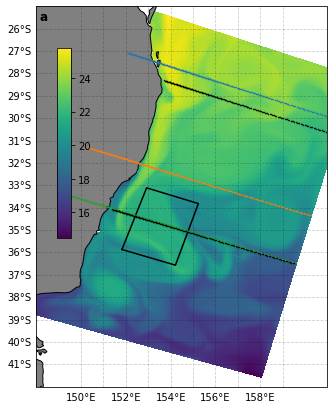

In [23]:



gs = gridspec.GridSpec(nrows=1,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7])
ax = None

ax1 = spatialMap_addGSSubplot(truth.temp.isel(s_rho=-1,ocean_time=0),gs,0,0,'a')
transectEta=270
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
transectEta=170
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
transectEta=120
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)

transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax1.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax1.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

# etaRangeMetric = [114, 184] #[115, 200]
# xiRangeMetric = [84, 149] #[85, 150]

etaRangeMetric = [84, 149]
xiRangeMetric = [114, 184]

boxLo,boxLa = calc_boxSpatial(truth,etaRange=etaRangeMetric,xiRange=xiRangeMetric)

ax1.plot(boxLo,boxLa,color='k')


In [ ]:
etas = np.array([84,149])
xis = np.array([114,184])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}

In [ ]:
# First calculate with rho0 (constant rho), for the to 2000m and to 700m.
rho0=1026
cp0=4181.3


cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*dT)

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*dT)

In [ ]:
plt.figure(figsize=[10,5])
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 700m',color='C4',linestyle='-')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

l3 = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, frameon=False)
plt.grid()



## Junde's box

In [ ]:
# now look at Junde's UOHC box
etas = np.array([34,79])
xis = np.array([89,159])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}


gs = gridspec.GridSpec(nrows=1,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7])
ax = None

ax1 = spatialMap_addGSSubplot(truth.temp.isel(s_rho=-1,ocean_time=0),gs,0,0,'a')
transectEta=270
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
transectEta=170
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
transectEta=120
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)

boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)

ax1.plot(boxLo,boxLa,color='k')

#### area-averaged vertically integrated OHC

In [ ]:

cutoffDepth = -700
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC700_0_ = (rho0*cp0*dz0*dT).isel(boxDict)
truth_OHC700_0_ = (OHC700_0_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

dz0 = OSSE_SSHSST.dz0.where(OSSE_SSHSST.z_rho0>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.where(OSSE_SSHSST.z_rho0>cutoffDepth, drop=True)
OHC700_0_ = (rho0*cp0*dz0*dT).isel(boxDict)
OSSE_SSHSST_OHC700_0_ = (OHC700_0_*OSSE_SSHSST_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(OSSE_SSHSST_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

dz0 = OSSE_SSHSST_XBT_S.dz0.where(OSSE_SSHSST_XBT_S.z_rho0>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.where(OSSE_SSHSST_XBT_S.z_rho0>cutoffDepth, drop=True)
OHC700_0_ = (rho0*cp0*dz0*dT).isel(boxDict)
OSSE_SSHSST_XBT_S_OHC700_0_ = (OHC700_0_*OSSE_SSHSST_XBT_S_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(OSSE_SSHSST_XBT_S_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)


cutoffDepth = -2000
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC2000_0_ = (rho0*cp0*dz0*dT).isel(boxDict)
truth_OHC2000_0_ = (OHC2000_0_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

dz0 = OSSE_SSHSST.dz0.where(OSSE_SSHSST.z_rho0>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.where(OSSE_SSHSST.z_rho0>cutoffDepth, drop=True)
OHC2000_0_ = (rho0*cp0*dz0*dT).isel(boxDict)
OSSE_SSHSST_OHC2000_0_ = (OHC2000_0_*OSSE_SSHSST_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(OSSE_SSHSST_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

dz0 = OSSE_SSHSST_XBT_S.dz0.where(OSSE_SSHSST_XBT_S.z_rho0>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.where(OSSE_SSHSST_XBT_S.z_rho0>cutoffDepth, drop=True)
OHC2000_0_ = (rho0*cp0*dz0*dT).isel(boxDict)
OSSE_SSHSST_XBT_S_OHC2000_0_ = (OHC2000_0_*OSSE_SSHSST_XBT_S_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(OSSE_SSHSST_XBT_S_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)


In [ ]:
plt.figure()
truth_OHC700_0_.sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-')
OSSE_SSHSST_OHC700_0_.sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700_0_.sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')

truth_OHC2000_0_.sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--')
OSSE_SSHSST_OHC2000_0_.sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000_0_.sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')

plt.legend(loc='center right',frameon=False)



#### integrated OHC

In [ ]:
# First calculate with rho0 (constant rho), for the to 2000m and to 700m.
rho0=1026
cp0=4181.3


cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*(dT+273.15))

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*(dT+273.15))
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*(dT+273.15))

plt.figure(figsize=[10,5])
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 700m',color='C4',linestyle='-')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

l3 = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, frameon=False)
plt.grid()

plt.ylim(1.12e23,1.16e23)

## Now look at mid-coast EAC box

In [ ]:
# now look at mid-coast EAC box
etas = np.array([174,219])
xis = np.array([100,170])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}


gs = gridspec.GridSpec(nrows=1,ncols=1)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[15,7])
ax = None

ax1 = spatialMap_addGSSubplot(truth.temp.isel(s_rho=-1,ocean_time=0),gs,0,0,'a')
transectEta=270
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
transectEta=170
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
transectEta=120
xx=truth.lon_rho.isel(eta_rho=transectEta)
yy=truth.lat_rho.isel(eta_rho=transectEta)
ax1.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)

transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax1.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
ax1.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)

ax1.plot(boxLo,boxLa,color='k')

In [ ]:
# First calculate with rho0 (constant rho), for the to 2000m and to 700m.
rho0=1026
cp0=4181.3

divideBy = 1e22

cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*(dT+273.15))/divideBy

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*(dT+273.15))/divideBy


fig = plt.figure(figsize=[10,5])
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 2],hspace=0.05)
ax = fig.add_subplot(gs.new_subplotspec((0, 0), colspan=2))
ax2 = fig.add_subplot(gs.new_subplotspec((1, 0), colspan=2))


truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax2,label='SSHSST_XBT < 700m',color='C4',linestyle='-')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(ax=ax,label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

# l3 = plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, frameon=False)
# plt.grid()
ax.set_xlabel('')
ax.set(xticklabels=[])
ax.set_xticklabels(())
ax.spines["bottom"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax.tick_params(axis="x", which="both", length=0)
ax.tick_params(labeltop="off")
ax2.tick_params(labeltop="off")
ax2.xaxis.tick_bottom()
d = .25  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax.plot([0], [0], transform=ax.transAxes, **kwargs)
ax2.plot([0], [1], transform=ax2.transAxes, **kwargs)
ax.grid()
ax2.grid()
# ax.set_ylim(3.89e22, 3.95e22)
# tempp = ax.get_yticks()/1e22
# ax.set_yticklabels(tempp)
# tempp = ax2.get_yticks()/1e22
# ax2.set_yticklabels(tempp)

/local/m68/deg581/tmp/ipykernel_3628129/3193352736.py:80: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tempp)
/local/m68/deg581/tmp/ipykernel_3628129/3193352736.py:160: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tempp)
/local/m68/deg581/tmp/ipykernel_3628129/3193352736.py:238: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(tempp)


CHANGE TO IN SITU TEMPERATURE!
ADD 273.15 !!!


/local/m68/deg581/tmp/ipykernel_3628129/3193352736.py:280: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


<Figure size 432x288 with 0 Axes>

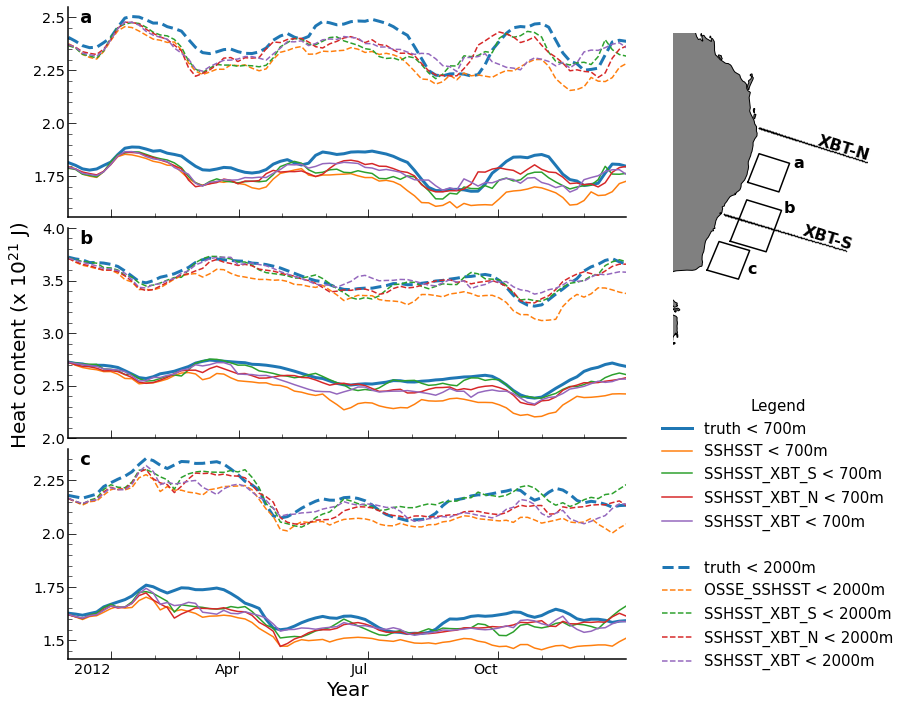

In [25]:
# consolidated plot of all OHCs

# set up figure
gs = gridspec.GridSpec(nrows=3,ncols=1,wspace=0.1, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[10,12])
ax = None

rho0=1026
cp0=4181.3

divideBy = 1e23


gs0 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0,0])
gs1 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[1,0])
gs2 = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[2,0])



# now look at mid-coast EAC box
etas = np.array([174,219])
xis = np.array([100,170])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}
cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*dT)

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*dT)

ax = fig.add_subplot(gs[0,0])
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 700m',color='C4',linestyle='-')
ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

ax.set_xticklabels([])
ax.set_title('')
ax.set_xlabel('')
tempp = ax.get_yticks()/1e21
ax.set_yticklabels(tempp)
ax.autoscale(enable=True, axis='x', tight=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", which='major', direction='in', length=8)
ax.tick_params(axis="y", which='major', direction='in', length=8)
ax.minorticks_on()
ax.tick_params(axis="x", which='minor', direction='in', length=4)
ax.tick_params(axis="y", which='minor', direction='in', length=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set(xticklabels=[])
ax.text(0.01, 0.99, ' a', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')




# now look at high EKE variability box
etas = np.array([84,149])
xis = np.array([114,184])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}
cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*dT)

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*dT)

ax = fig.add_subplot(gs[1,0])
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 700m',color='C4',linestyle='-')
ax.plot(np.NaN, np.NaN, '-', color='none', label='')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

ax.set_xticklabels([])
ax.set_title('')
ax.set_xlabel('',fontsize=14)
tempp = ax.get_yticks()/1e21
ax.set_yticklabels(tempp)
ax.autoscale(enable=True, axis='x', tight=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", which='major', direction='in', length=8)
ax.tick_params(axis="y", which='major', direction='in', length=8)
ax.minorticks_on()
ax.tick_params(axis="x", which='minor', direction='in', length=4)
ax.tick_params(axis="y", which='minor', direction='in', length=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
ax.set(xticklabels=[])
ax.text(0.01, 0.99, ' b', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')
ax.set_ylim([2e21,6e21])

# now look at Junde's UOHC box
etas = np.array([34,79])
xis = np.array([89,159])

boxDict = {'xi_rho': slice(xis[0],xis[1]),
        'eta_rho': slice(etas[0],etas[1])}
cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC700 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC700 = (rho0*cp0*dV0*dT)

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT_N.dV.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_N.temp.isel(boxDict).where(OSSE_SSHSST_XBT_N.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_N_OHC2000 = (rho0*cp0*dV0*dT)
dV0 = OSSE_SSHSST_XBT.dV.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT.temp.isel(boxDict).where(OSSE_SSHSST_XBT.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_OHC2000 = (rho0*cp0*dV0*dT)

ax = fig.add_subplot(gs[2,0])
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-',linewidth=3)
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')
OSSE_SSHSST_XBT_N_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 700m',color='C3',linestyle='-')
OSSE_SSHSST_XBT_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 700m',color='C4',linestyle='-')
ax.plot(np.NaN, np.NaN, '-', color='none', label=' ')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--',linewidth=3)
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')
OSSE_SSHSST_XBT_N_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_N < 2000m',color='C3',linestyle='--')
OSSE_SSHSST_XBT_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT < 2000m',color='C4',linestyle='--')

# ax.grid()
ax.set_title('')
ax.set_xlabel('Year',fontsize=20)
tempp = ax.get_yticks()/1e21
ax.set_yticklabels(tempp)
ax.autoscale(enable=True, axis='x', tight=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis="x", which='major', direction='in', length=8)
ax.tick_params(axis="y", which='major', direction='in', length=8)
ax.minorticks_on()
ax.tick_params(axis="x", which='minor', direction='in', length=4)
ax.tick_params(axis="y", which='minor', direction='in', length=4)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 4, 7, 10)))
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(
    mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.tick_params(axis='x', rotation=0, labelsize='x-large')
ax.tick_params(axis='y', rotation=0, labelsize='x-large')
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(1.5)
fig.text(0.04, 0.5, 'Heat content (x$~10^{21}~$J)', va='center', rotation='vertical', fontsize=20)
ax.text(0.01, 0.99, ' c', transform=ax.transAxes,fontsize=18, fontweight='bold', va='top')

legend = plt.legend(bbox_to_anchor=(1.04,1.3), loc="upper left", frameon=False, prop={'size': 15}, title='Legend',title_fontsize=15)
# legend.set_title('Legend',size=18)


# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
# axins = ax.inset_axes(bounds=[0.5, 0.5, 0.47, 0.47],projection='ccrs.PlateCarree()',width="100%", height="100%",
#                    bbox_to_anchor=(1.05, .6, .5, .4),
#                    bbox_transform=ax.transAxes, loc=2, borderpad=0)#, projection=ccrs.PlateCarree())

axins = fig.add_axes([.95, .45, 0.3, 0.4], projection=ccrs.PlateCarree())
axins.set_extent([148, 161, -45, -22])
feature = axins.add_feature(Coast, edgecolor='black',facecolor='gray')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
# gl.xlocator = mticker.FixedLocator(np.arange(150,160,2))
# gl.ylocator = mticker.FixedLocator(np.arange(-45,45,2))
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(False)
axins.spines['top'].set_visible(False)

# transectEta=270
# xx=truth.lon_rho.isel(eta_rho=transectEta)
# yy=truth.lat_rho.isel(eta_rho=transectEta)
# axins.plot(xx,yy,linestyle='none',color="C0",marker='.',markersize=1,zorder=12)
# transectEta=170
# xx=truth.lon_rho.isel(eta_rho=transectEta)
# yy=truth.lat_rho.isel(eta_rho=transectEta)
# axins.plot(xx,yy,linestyle='none',color="C1",marker='.',markersize=1,zorder=12)
# transectEta=120
# xx=truth.lon_rho.isel(eta_rho=transectEta)
# yy=truth.lat_rho.isel(eta_rho=transectEta)
# axins.plot(xx,yy,linestyle='none',color="C2",marker='.',markersize=1,zorder=12)

transectEta=255
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
axins.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)
transectEta=119
xx=truth.lon_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
yy=truth.lat_rho.isel(eta_rho=transectEta,xi_rho=slice(74,271))
axins.plot(xx,yy,linestyle='none',color="k",marker='.',markersize=1,zorder=12)

# now look at Junde's UOHC box
etas = np.array([34,79])
xis = np.array([89,159])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='k')

# now look at high EKE variability box
etas = np.array([84,149])
xis = np.array([114,184])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='k')

# now look at mid-coast EAC box
etas = np.array([174,219])
xis = np.array([100,170])
boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
axins.plot(boxLo,boxLa,color='k')

axins.annotate('a', xy=(156,-31),xycoords='data',fontweight='bold',fontsize=16)
axins.annotate('b', xy=(155.4,-34),xycoords='data',fontweight='bold',fontsize=16)
axins.annotate('c', xy=(153,-38),xycoords='data',fontweight='bold',fontsize=16)
axins.annotate('XBT-N', xy=(157.5,-30.5),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)
axins.annotate('XBT-S', xy=(156.5,-36.45),xycoords='data',fontweight='bold',rotation=-17,fontsize=16)


print('CHANGE TO IN SITU TEMPERATURE!')
print('ADD 273.15 !!!')

In [162]:
BREAKPOINT

NameError: name 'BREAKPOINT' is not defined

#### Repeat calculations with time-varying rho

In [ ]:
truth["rho"]=xroms.density(truth.temp,truth.salt)
truth = truth.drop_vars('salt')

OSSE_SSHSST["rho"]=xroms.density(OSSE_SSHSST.temp,OSSE_SSHSST.salt)
OSSE_SSHSST = OSSE_SSHSST.drop_vars('salt')

OSSE_SSHSST_XBT_S["rho"]=xroms.density(OSSE_SSHSST_XBT_S.temp,OSSE_SSHSST_XBT_S.salt)
OSSE_SSHSST_XBT_S = OSSE_SSHSST_XBT_S.drop_vars('salt')

OSSE_SSHSST_XBT_N["rho"]=xroms.density(OSSE_SSHSST_XBT_N.temp,OSSE_SSHSST_XBT_N.salt)
OSSE_SSHSST_XBT_N = OSSE_SSHSST_XBT_N.drop_vars('salt')

OSSE_SSHSST_XBT["rho"]=xroms.density(OSSE_SSHSST_XBT.temp,OSSE_SSHSST_XBT.salt)
OSSE_SSHSST_XBT = OSSE_SSHSST_XBT.drop_vars('salt')

/g/data/fu5/deg581/miniconda3/envs/devel3.9/lib/python3.9/site-packages/xarray/core/dataarray.py:784: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [33]:

cutoffDepth = -700
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST.rho.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST_XBT_S.rho.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho*cp0*dV0*dT)

cutoffDepth = -2000
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST.rho.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST_XBT_S.rho.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho*cp0*dV0*dT)

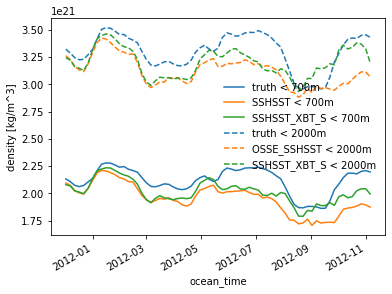

In [34]:
plt.figure()
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-')
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--')
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')

plt.legend(loc='center right',frameon=False)


In [21]:

cutoffDepth = -700
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC700 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST.rho.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC700 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST_XBT_S.rho.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC700 = (rho*cp0*dV0*dT)

cutoffDepth = -2000
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
truth_OHC2000 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST.rho.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST.dV.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST.temp.isel(boxDict).where(OSSE_SSHSST.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_OHC2000 = (rho*cp0*dV0*dT)

rho=OSSE_SSHSST_XBT_S.rho.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = OSSE_SSHSST_XBT_S.dV.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = OSSE_SSHSST_XBT_S.temp.isel(boxDict).where(OSSE_SSHSST_XBT_S.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OSSE_SSHSST_XBT_S_OHC2000 = (rho*cp0*dV0*dT)

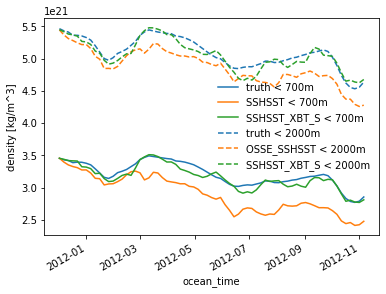

In [22]:
plt.figure()
truth_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 700m',color='C0',linestyle='-')
OSSE_SSHSST_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST < 700m',color='C1',linestyle='-')
OSSE_SSHSST_XBT_S_OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 700m',color='C2',linestyle='-')

truth_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='truth < 2000m',color='C0',linestyle='--')
OSSE_SSHSST_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='OSSE_SSHSST < 2000m',color='C1',linestyle='--')
OSSE_SSHSST_XBT_S_OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='SSHSST_XBT_S < 2000m',color='C2',linestyle='--')

plt.legend(loc='center right',frameon=False)


## STOP

In [27]:
stop

NameError: name 'stop' is not defined

In [ ]:

cutoffDepth = -700
rho=truth.rho.where(truth.z_rho0>cutoffDepth, drop=True)
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC700_ = (rho*cp0*dz0*dT).isel(boxDict)
truth_OHC700_ = (OHC700_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -2000
rho=truth.rho.where(truth.z_rho0>cutoffDepth, drop=True)
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC2000_ = (rho*cp0*dz0*dT).isel(boxDict)
truth_OHC2000_ = (OHC2000_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)


In [70]:
rho0=1026
cp0=3990
cutoffDepth = -6000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
fullOHC0 = (1026*3990*dV0*dT)

cutoffDepth = -500
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OHC500 = (1026*3990*dV0*dT)

cutoffDepth = -700
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OHC700 = (1026*3990*dV0*dT)

cutoffDepth = -2000
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OHC2000 = (1026*3990*dV0*dT)

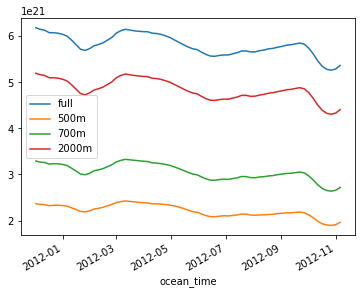

In [71]:
plt.figure()
fullOHC0.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='full')
OHC500.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='500m')
OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='700m')
OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='2000m')
plt.legend()



In [98]:
rho0=1026
cp0=3990
cutoffDepth = -6000
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
fullOHC0_ = (1026*3990*dz0*dT).isel(boxDict)
fullOHC0_ = (fullOHC0_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -500
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC500_0_ = (1026*3990*dz0*dT).isel(boxDict)
OHC500_0_ = (OHC500_0_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -700
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC700_0_ = (1026*3990*dz0*dT).isel(boxDict)
OHC700_0_ = (OHC700_0_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -2000
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC2000_0_ = (1026*3990*dz0*dT).isel(boxDict)
OHC2000_0_ = (OHC2000_0_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

In [74]:
grid = makeROMSGridObject(truth_bu)

In [ ]:
plt.figure()
fullOHC0_.sum(dim='s_rho').plot(label='full')
OHC500_0_.sum(dim='s_rho').plot(label='500m')
OHC700_0_.sum(dim='s_rho').plot(label='700m')
OHC2000_0_.sum(dim='s_rho').plot(label='2000m')
plt.legend()


In [99]:
cp0=3990

cutoffDepth = -6000
rho=truth.rho.where(truth.z_rho0>cutoffDepth, drop=True)
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
fullOHC_ = (rho*cp0*dz0*dT).isel(boxDict)
fullOHC_ = (fullOHC_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -500
rho=truth.rho.where(truth.z_rho0>cutoffDepth, drop=True)
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC500_ = (rho*cp0*dz0*dT).isel(boxDict)
OHC500_ = (OHC500_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -700
rho=truth.rho.where(truth.z_rho0>cutoffDepth, drop=True)
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC700_ = (rho*cp0*dz0*dT).isel(boxDict)
OHC700_ = (OHC700_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

cutoffDepth = -2000
rho=truth.rho.where(truth.z_rho0>cutoffDepth, drop=True)
dz0 = truth.dz0.where(truth.z_rho0>cutoffDepth, drop=True)
dT = truth.temp.where(truth.z_rho0>cutoffDepth, drop=True)
OHC2000_ = (rho*cp0*dz0*dT).isel(boxDict)
OHC2000_ = (OHC2000_*truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)/(truth_bu.dA.isel(boxDict)).sum(dim=['eta_rho','xi_rho'],skipna=True)

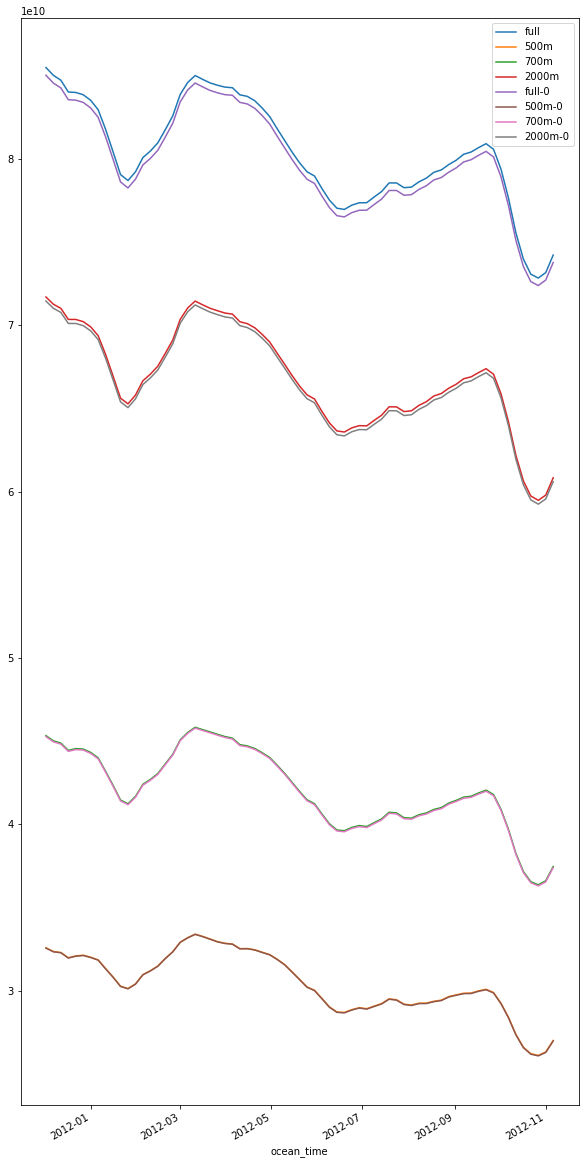

In [101]:
plt.figure(figsize=[10,20])
fullOHC_.sum(dim='s_rho').plot(label='full')
OHC500_.sum(dim='s_rho').plot(label='500m')
OHC700_.sum(dim='s_rho').plot(label='700m')
OHC2000_.sum(dim='s_rho').plot(label='2000m')
fullOHC0_.sum(dim='s_rho').plot(label='full-0')
OHC500_0_.sum(dim='s_rho').plot(label='500m-0')
OHC700_0_.sum(dim='s_rho').plot(label='700m-0')
OHC2000_0_.sum(dim='s_rho').plot(label='2000m-0')
plt.legend()

In [102]:
cp0=3990

cutoffDepth = -6000
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
fullOHC0 = (rho*3990*dV0*dT)

cutoffDepth = -500
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OHC500 = (rho*3990*dV0*dT)

cutoffDepth = -700
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OHC700 = (rho*3990*dV0*dT)

cutoffDepth = -2000
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dV0 = truth.dV.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
dT = truth.temp.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
OHC2000 = (rho*3990*dV0*dT)

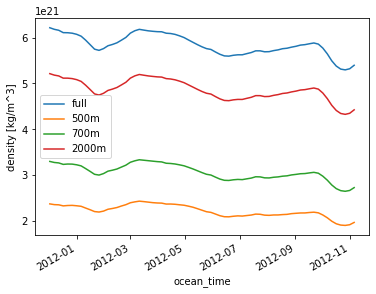

In [103]:
plt.figure()
fullOHC0.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='full')
OHC500.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='500m')
OHC700.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='700m')
OHC2000.sum(dim='xi_rho').sum(dim='eta_rho').sum(dim='s_rho').plot(label='2000m')
plt.legend()


In [109]:
rho=truth.rho.isel(boxDict).where(truth.z_rho0.isel(boxDict)>cutoffDepth, drop=True)
rho.mean(dim='s_rho').mean(dim='eta_rho').mean(dim='xi_rho')

<xarray.DataArray 'rho' (ocean_time: 69)>
array([1027.2776075 , 1027.28417563, 1027.27812321, 1027.31843797,
       1027.29372193, 1027.26825695, 1027.2173797 , 1027.15302663,
       1027.18009576, 1027.17425418, 1027.18360936, 1027.18690302,
       1027.17871209, 1027.11648289, 1027.10027784, 1027.09071608,
       1027.03928731, 1027.00680586, 1026.99405607, 1026.99373351,
       1026.97455806, 1027.00033609, 1027.04997731, 1027.08580654,
       1027.09037805, 1027.0844452 , 1027.12123579, 1027.10441417,
       1027.08387438, 1027.1093632 , 1027.10896105, 1027.11936592,
       1027.13728439, 1027.21285873, 1027.27870956, 1027.34764312,
       1027.36129349, 1027.41587056, 1027.50455204, 1027.54686114,
       1027.57925518, 1027.58013543, 1027.56426376, 1027.59489405,
       1027.59490714, 1027.59436551, 1027.5755385 , 1027.58731255,
       1027.63341822, 1027.6484135 , 1027.65465618, 1027.67247825,
       1027.67803155, 1027.68115295, 1027.67843021, 1027.67789054,
       1027.67478103, 1027.66984157, 1027.66563247, 1027.66144819,
       1027.67180261, 1027.70337448, 1027.75193221, 1027.81315899,
       1027.84691939, 1027.85776956, 1027.85136544, 1027.81108084,
       1027.71151375])
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2011-12-02 2011-12-07 ... 2012-11-06
Attributes:
    name:       rho
    long_name:  density
    units:      kg/m^3